In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score,roc_auc_score,precision_recall_curve,auc,roc_curve
import numpy as np
import pickle
import joblib
from scipy import stats
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [2]:
with open('genes.pickle', 'rb') as f:
    gene_annotation = pickle.load(f)
ordered_genes = sorted(list(gene_annotation.keys()))

tmpgeneTSS = np.loadtxt('ensemblTSS.txt', dtype='str')
geneTSS_dic = {tmpgeneTSS[i, 0]: int(tmpgeneTSS[i, 1]) for i in range(tmpgeneTSS.shape[0])}


In [7]:
def part2(cell,clf=None,mtype=None,fold=0, extra_fea=None):
    all_var_ids=set()

    if mtype == 'borzoi':
        input = np.load('borzoi_data/variant_scores/' + cell + '_diff_l2.npy')

    else:
        input = np.load('all_enf_data/' + cell + '_pred_diff_all.npy')

    data = np.loadtxt('eqtl_data/' + cell + '.txt', dtype='str')
    geneids = data[:, 2].astype('int')
    tss_loc = np.array([geneTSS_dic[ordered_genes[gid]] for gid in geneids])
    variant_loc = data[:, 7].astype('int')
    dists = np.abs(tss_loc // 1000 - variant_loc // 1000)
    fi=np.where(dists <= 496)[0]
    data=data[fi]
    input=input[fi]
    if extra_fea is not None:
        input=np.concatenate((input,extra_fea),axis=1)


    geneids = data[:, 2].astype('int')
    tss_loc = np.array([geneTSS_dic[ordered_genes[gid]] for gid in geneids])
    variant_loc = data[:, 7].astype('int')
    dists1 = np.abs(tss_loc - variant_loc)
    dists1 = dists1[:, np.newaxis]

    label = data[:, 0].astype('int')
    index=np.arange(input.shape[0])

    np.random.seed(24)
    np.random.shuffle(index)

    test_start, test_end = int(fold * 0.2 * input.shape[0]), int((fold + 1)* 0.2 * input.shape[0])
    train_i= np.concatenate((index[:test_start], index[test_end:]))
    data=data[train_i]

    train_input=input[train_i]
    train_label=label[train_i]

    if clf is None:
        traininp=np.vstack(train_input)
        clf=RandomForestClassifier(n_jobs=-1,random_state=24,max_features='log2').fit(traininp, train_label)
        
    if mtype == 'borzoi':
        input = np.load('borzoi_data/variant_scores/' + cell + '_diff_l2.npy')
    else:
        input = np.load('all_enf_data/' + cell + '_pred_diff_all.npy')
 

    data = np.loadtxt('eqtl_data/' + cell + '.txt', dtype='str')

    geneids = data[:, 2].astype('int')
    tss_loc = np.array([geneTSS_dic[ordered_genes[gid]] for gid in geneids])
    variant_loc = data[:, 7].astype('int')
    dists = np.abs(tss_loc // 1000 - variant_loc // 1000)
    fi = np.where(dists <= 496)[0]
    data = data[fi]
    input = input[fi]
    if extra_fea is not None:
        input=np.concatenate((input,extra_fea),axis=1)
    geneids = data[:, 2].astype('int')
    tss_loc = np.array([geneTSS_dic[ordered_genes[gid]] for gid in geneids])
    variant_loc = data[:, 7].astype('int')
    dists = np.abs(tss_loc - variant_loc)
    dists = dists[:, np.newaxis]


    label = data[:, 0].astype('int')

    index=np.arange(input.shape[0])
    np.random.seed(24)
    np.random.shuffle(index)

    test_start, test_end = int(fold * 0.2 * input.shape[0]), int((fold + 1)*0.2 * input.shape[0])
    test_i = index[test_start:test_end]


    test_dist_i=dists[test_i].squeeze()
    test_input=input[test_i]
    test_label=label[test_i]


    test_dist_input = test_input[test_dist_i <3000]
    test_dist_label = test_label[test_dist_i <3000]


    testspred=clf.predict_proba(test_input)[:,1]
    tests_dist_pred = clf.predict_proba(test_dist_input)[:, 1]

    roc=roc_auc_score(test_label,testspred)
    ap=average_precision_score(test_label,testspred)
    roc1 = roc_auc_score(test_dist_label, tests_dist_pred)
    ap1 = average_precision_score(test_dist_label, tests_dist_pred)
    print(fold,roc,ap,roc1,ap1)

    return test_label,testspred


In [ ]:
extra_fea=None
targs,preds,targs1,preds1,targs2,preds2={},{},{},{},{},{}
for cell in ['thyroid','artery_tibial','colon_sigmoid','pancreas','adipose_subcutaneous']:
    targs[cell]=[]
    preds[cell]=[]
    targs1[cell]=[]
    preds1[cell]=[]
    targs2[cell]=[]
    preds2[cell]=[]
    oned_rep=np.load( cell+'_reps.npy')
    twod_rep=np.load(cell+'_2dreps.npy')
    extra_fea=np.concatenate((stats.zscore(oned_rep[:,0,:],axis=1),stats.zscore(oned_rep[:,1,:],axis=1),
                              stats.zscore(twod_rep,axis=1)  ),axis=1)

    for fold in range(5):
        targ,pred=part2(cell,clf=None,mtype='borzoi',fold=fold,extra_fea=extra_fea)
        targ1,pred1 = part2(cell, clf=None, mtype='borzoi', fold=fold, extra_fea=None)
        targ2,pred2 = part2(cell, clf=None, mtype='enformer', fold=fold, extra_fea=None)
        targs[cell].append(targ)
        preds[cell].append(pred)
        targs1[cell].append(targ1)
        preds1[cell].append(pred1)
        targs2[cell].append(targ2)
        preds2[cell].append(pred2)
    targs[cell]=np.concatenate(targs[cell])
    preds[cell]=np.concatenate(preds[cell])
    targs1[cell]=np.concatenate(targs1[cell])
    preds1[cell]=np.concatenate(preds1[cell])
    targs2[cell]=np.concatenate(targs2[cell])
    preds2[cell]=np.concatenate(preds2[cell])
    

Text(0, 0.5, 'TPR')

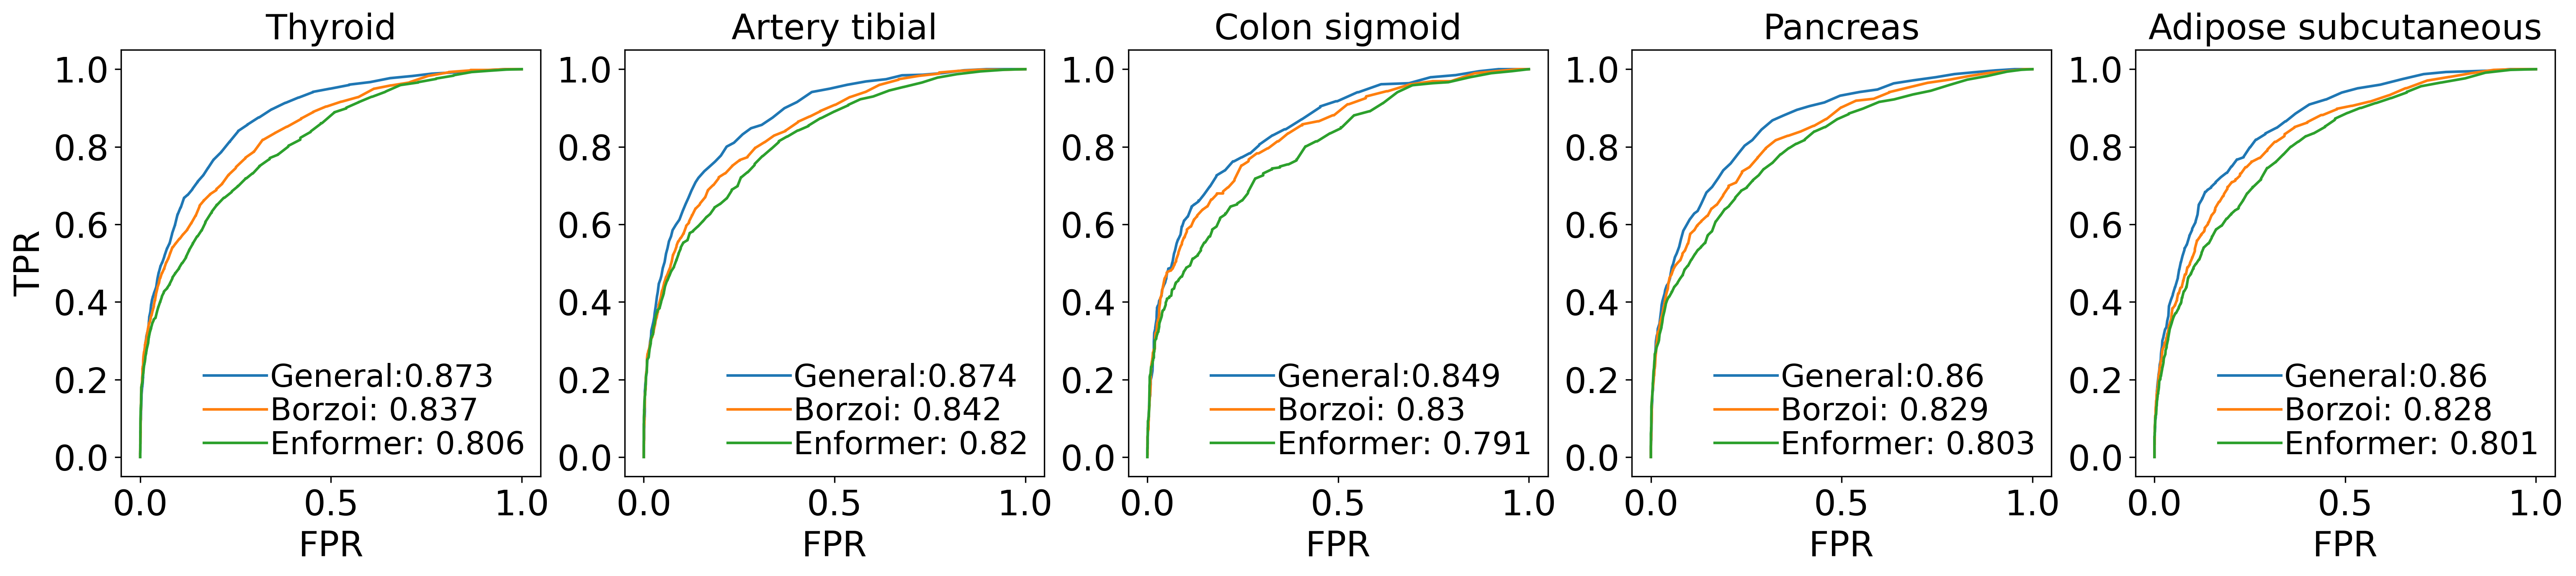

In [9]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.dpi'] = 300
fig,axs=plt.subplots(ncols=5,figsize=(25,4.5))
for i,cell in enumerate(['thyroid','artery_tibial','colon_sigmoid','pancreas','adipose_subcutaneous']):
    p, r, t = precision_recall_curve(targs[cell],preds[cell])
    fpr, tpr, thresholds = roc_curve(targs[cell],preds[cell])
    
    p1, r1, t = precision_recall_curve(targs1[cell],preds1[cell])
    fpr1, tpr1, thresholds = roc_curve(targs1[cell],preds1[cell])
    
    p2, r2, t = precision_recall_curve(targs2[cell],preds2[cell])
    fpr2, tpr2, thresholds = roc_curve(targs2[cell],preds2[cell])
    
    axs[i].plot(fpr,tpr,label= 'General:%s'%(np.around(auc(fpr,tpr),3)))
    axs[i].plot(fpr1,tpr1,label= 'Borzoi: %s'%(np.around(auc(fpr1,tpr1),3)))
    axs[i].plot(fpr2,tpr2,label= 'Enformer: %s'%(np.around(auc(fpr2,tpr2),3)))
    axs[i].legend(loc='lower right',labelspacing=0.1,handletextpad=0.1,frameon=False,borderaxespad=0.1,fontsize=18)
    axs[i].set_title(cell.replace('_',' ').capitalize(),fontsize=20)
    axs[i].set_xlabel('FPR')
axs[0].set_ylabel('TPR')

Text(0, 0.5, 'Precision')

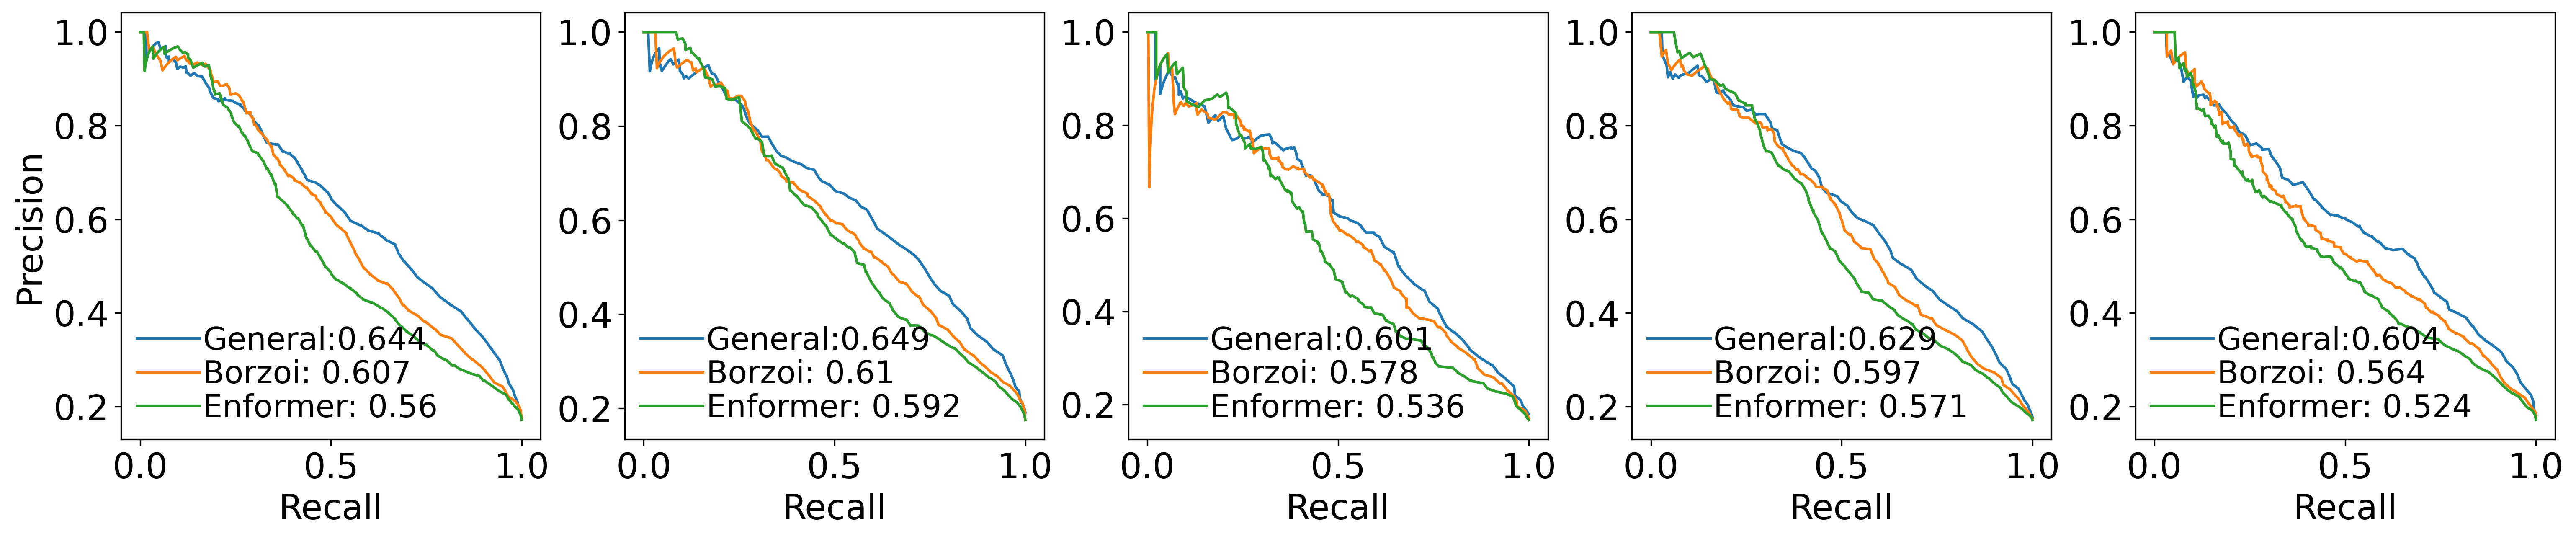

In [10]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.dpi'] = 300
fig,axs=plt.subplots(ncols=5,figsize=(25,4.5))
for i,cell in enumerate(['thyroid','artery_tibial','colon_sigmoid','pancreas','adipose_subcutaneous']):
    p, r, t = precision_recall_curve(targs[cell],preds[cell])
    fpr, tpr, thresholds = roc_curve(targs[cell],preds[cell])
    
    p1, r1, t = precision_recall_curve(targs1[cell],preds1[cell])
    fpr1, tpr1, thresholds = roc_curve(targs1[cell],preds1[cell])
    
    p2, r2, t = precision_recall_curve(targs2[cell],preds2[cell])
    fpr2, tpr2, thresholds = roc_curve(targs2[cell],preds2[cell])
    
    axs[i].plot(r,p,label= 'General:%s'%(np.around(auc(r,p),3)))
    axs[i].plot(r1,p1,label= 'Borzoi: %s'%(np.around(auc(r1,p1),3)))
    axs[i].plot(r2,p2,label= 'Enformer: %s'%(np.around(auc(r2,p2),3)))
    axs[i].legend(loc='lower left',labelspacing=0.1,handletextpad=0.1,frameon=False,borderaxespad=0.1,fontsize=18)
    axs[i].set_xlabel('Recall')
axs[0].set_ylabel('Precision')